# Independent multi-series forecasting


In [univariate time series forecasting](https://joaquinamatrodrigo.github.io/skforecast/latest/quick-start/introduction-forecasting.html), a single time series is modeled as a linear or nonlinear combination of its lags, where past values of the series are used to forecast its future. In multi-series forecasting, two or more time series are modeled together using a single model.


In **independent multi-series forecasting** a single model is trained for all time series, but each time series remains independent of the others, meaning that past values of one series are not used as predictors of other series. However, modeling them together is useful because the series may follow the same intrinsic pattern regarding their past and future values. For instance, the sales of products A and B in the same store may not be related, but they follow the same dynamics, that of the store.

<p align="center"><img src="../img/forecaster_multi_series_train_matrix_diagram.png" style="width: 700px"></p>

<center><font size="2.5"> <i>Transformation of two time series and an exogenous variable into the matrices needed to train a machine learning model in a multi-series context.</i></font></center>

To predict the next *n* steps, the strategy of [recursive multi-step forecasting](https://joaquinamatrodrigo.github.io/skforecast/latest/quick-start/introduction-forecasting.html#multi-step-forecasting) is applied, with the only difference being that the series name for which to estimate the predictions needs to be indicated.

<p align="center"><img src="../img/forecaster_multi_series_prediction_diagram.png" style="width: 700px"></p>

<center><font size="2.5"> <i>Diagram of recursive forecasting with multiple independent time series.</i></font></center>

Using the `ForecasterAutoregMultiSeries` and `ForecasterAutoregMultiSeriesCustom` classes, it is possible to easily build machine learning models for independent multi-series forecasting.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4;">

<p class="title">
    <i class="fa-circle-exclamation fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>

See <a href="https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/dependent-multi-series-multivariate-forecasting">ForecasterAutoregMultiVariate</a> for dependent multi-series forecasting (multivariate time series).

</div>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

## Data

In [2]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/simulated_items_sales.csv')
data = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()
data.head()

,item_1,item_2,item_3
date,,,
2012-01-01,8.253175,21.047727,19.429739
2012-01-02,22.777826,26.578125,28.009863
2012-01-03,27.549099,31.751042,32.078922
2012-01-04,25.895533,24.567708,27.252276
2012-01-05,21.379238,18.191667,20.357737


In [3]:
# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2012-01-01 00:00:00 --- 2014-07-15 00:00:00  (n=927)
Test dates  : 2014-07-16 00:00:00 --- 2015-01-01 00:00:00  (n=170)


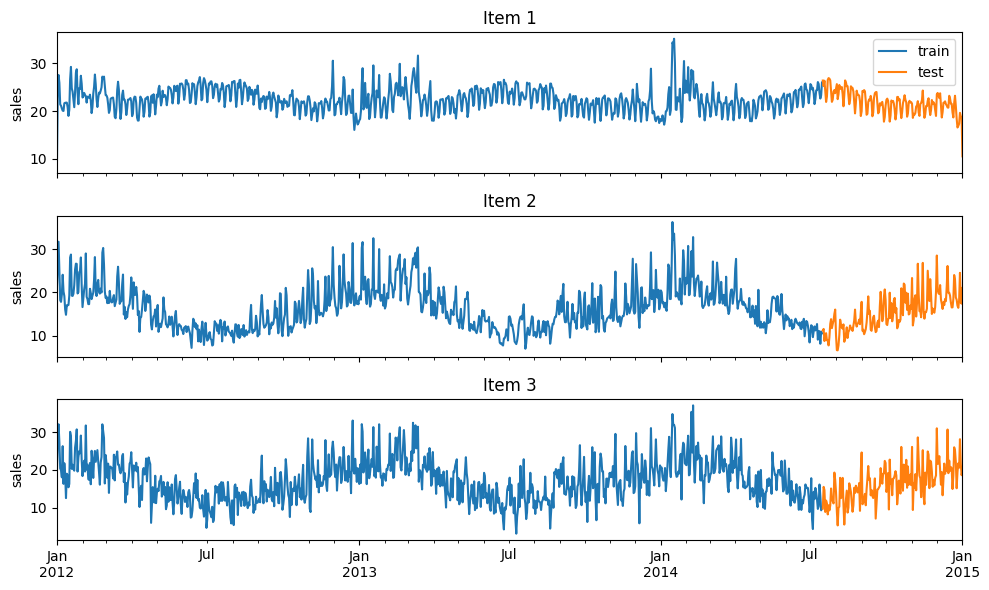

In [4]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), sharex=True)

data_train['item_1'].plot(label='train', ax=axes[0])
data_test['item_1'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('sales')
axes[0].set_title('Item 1')
axes[0].legend()

data_train['item_2'].plot(label='train', ax=axes[1])
data_test['item_2'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('sales')
axes[1].set_title('Item 2')

data_train['item_3'].plot(label='train', ax=axes[2])
data_test['item_3'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('sales')
axes[2].set_title('Item 3')

fig.tight_layout()
plt.show();

## Train and predict ForecasterAutoregMultiSeries

In [5]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

forecaster.fit(series=data_train)
forecaster

ForecasterAutoregMultiSeries 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: None 
Transformer for exog: None 
Window size: 24 
Series levels (names): ['item_1', 'item_2', 'item_3'] 
Series weights: None 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-07-15 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2023-03-08 15:22:57 
Last fit date: 2023-03-08 15:22:57 
Skforecast version: 0.7.0 
Python version: 3.9.13 
Forecaster id: None 

Two methods can be use to predict the next n steps: `predict()` or `predict_interval()`. The argument `levels` is used to indicate for which series estimate predictions. If `None` all series will be predicted.

In [6]:
# Predict and predict_interval
# ==============================================================================
steps = 24

# Predictions for item_1
predictions_item_1 = forecaster.predict(steps=steps, levels='item_1')
display(predictions_item_1.head(3))

# Interval predictions for item_1 and item_2
predictions_intervals = forecaster.predict_interval(steps=steps, levels=['item_1', 'item_2'])
display(predictions_intervals.head(3))

,item_1
2014-07-16,25.497376
2014-07-17,24.866972
2014-07-18,24.281173


,item_1,item_1_lower_bound,item_1_upper_bound,item_2,item_2_lower_bound,item_2_upper_bound
2014-07-16,25.497376,23.220087,28.226068,10.694506,7.093046,15.518896
2014-07-17,24.866972,22.141168,27.389805,11.080091,6.467676,16.534679
2014-07-18,24.281173,21.688393,26.981395,11.490882,7.077863,16.762530


## Backtesting Multi Series

As in the `predict` method, the `levels` at which [backtesting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html) is performed must be indicated. The argument can also be set to `None` to perform backtesting at all levels.

In [7]:
# Backtesting Multi Series
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster         = forecaster,
                                           series             = data,
                                           levels             = None,
                                           steps              = 24,
                                           metric             = 'mean_absolute_error',
                                           initial_train_size = len(data_train),
                                           refit              = True,
                                           fixed_train_size   = True,
                                           verbose            = False
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

Backtest metrics


,levels,mean_absolute_error
0,item_1,1.360675
1,item_2,2.332392
2,item_3,3.155592



Backtest predictions


,item_1,item_2,item_3
2014-07-16,25.497376,10.694506,11.275026
2014-07-17,24.866972,11.080091,11.313510
2014-07-18,24.281173,11.490882,13.030112
2014-07-19,23.515499,11.548922,13.378282


## Hyperparameter tuning and lags selection Multi Series

Functions `grid_search_forecaster_multiseries` and `random_search_forecaster_multiseries` in the module `model_selection_multiseries` allow for lag and hyperparameter optimization. The optimization is performed in the same way as in the other forecasters, [see the user guide here](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/hyperparameter-tuning-and-lags-selection.html), except for the `levels` argument:

+ `levels`: level(s) at which the forecaster is optimized, for example:

    + If `levels = ['item_1', 'item_2', 'item_3']` (Same as `levels = None`), the function will search for the lags and hyperparameters that minimize the average error of the predictions of all the time series. The resulting metric will be the **average of all levels**. 

    + If `levels = 'item_1'` (Same as `levels = ['item_1']`), the function will search for the lags and hyperparameters that minimize the error of the `item_1` predictions. The resulting metric will be the one calculated for `item_1`.

The following example shows how to use `grid_search_forecaster_multiseries` to find the best lags and model hyperparameters for all time series:

In [8]:
# Create forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

In [9]:
# Grid search Multi Series
# ==============================================================================
lags_grid = [24, 48]
param_grid = {'alpha': [0.01, 0.1, 1]}

levels = ['item_1', 'item_2', 'item_3']

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              levels              = levels,
              lags_grid           = lags_grid,
              param_grid          = param_grid,
              steps               = 24,
              metric              = 'mean_absolute_error',
              initial_train_size  = len(data_train),
              refit               = True,
              fixed_train_size    = True,
              return_best         = False,
              verbose             = False
          )

results

6 models compared for 3 level(s). Number of iterations: 6.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


,levels,lags,params,mean_absolute_error,alpha
5,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},2.207648,1.00
4,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},2.207700,0.10
3,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},2.207706,0.01
2,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},2.335039,1.00
1,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},2.335149,0.10
0,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},2.335161,0.01


## Weights in multi-series

The weights are used to control the influence that each observation has on the training of the model. `ForecasterAutoregMultiseries` accepts two types of weights:

+ `series_weights` controls the relative importance of each series. If a series has twice as much weight as the others, the observations of that series influence the training twice as much. The higher the weight of a series relative to the others, the more the model will focus on trying to learn that series.

+ `weight_func` controls the relative importance of each observation according to its index value. For example, a function that assigns a lower weight to certain dates.

If the two types of weights are indicated, they are **multiplied to create the final weights**. The resulting `sample_weight` cannot have negative values.

<p align="center"><img src="../img/forecaster_multi_series_sample_weight.png" style="width: 900px"></p>

+ `series_weights` is a dict of the form `{'series_column_name': float}`. If a series is used during `fit` and is not present in `series_weights`, it will have a weight of 1.

+ `weight_func` is a function that defines the individual weights of each sample **based on the index**. 
  
    + If it is a `callable`, the same function will apply to all series. 
  
    + If it is a `dict` of the form `{'series_column_name': callable}`, a different function can be used for each series. A weight of 1 is given to all series not present in `weight_func`.

In [10]:
# Weights in Multi-Series
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )
    
    return weights

forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = custom_weights,
                 series_weights     = {'item_1': 1., 'item_2': 2., 'item_3': 1.} # Same as {'item_2': 2.}
             )

forecaster.fit(series=data_train)
forecaster.predict(steps=24).head(3)

,item_1,item_2,item_3
2014-07-16,25.547560,10.527454,11.195018
2014-07-17,24.779779,10.987891,11.424717
2014-07-18,24.182702,11.375158,13.090853


<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition warning" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100;">

<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b> &nbsp Warning</b>
</p>

The <code>weight_func</code> and <code>series_weights</code> arguments will be ignored if the regressor does not accept <code>sample_weight</code> in its <code>fit</code> method.

</div>

The source code of the `weight_func` added to the forecaster is stored in the argument `source_code_weight_func`. If `weight_func` is a `dict`, it will be a `dict` of the form `{'series_column_name': source_code_weight_func}` .

In [11]:
print(forecaster.source_code_weight_func)

def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )
    
    return weights



## Scikit-learn transformers in multi-series

Learn more about [using scikit-learn transformers](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/sklearn-transformers-and-pipeline.html) with skforecast.

+  If `transformer_series` is a `transformer` the same transformation will be applied to all series. 
+  If `transformer_series` is a `dict` a different transformation can be set for each series. Series not present in the dict will not have any transformation applied to them.

In [12]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24,
                 transformer_series = {'item_1': StandardScaler(), 'item_2': StandardScaler()},
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

forecaster.fit(series=data_train)
forecaster

c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:427: UserWarning: {'item_3'} not present in `transformer_series`. No transformation is applied to these series.
  warnings.warn(


ForecasterAutoregMultiSeries 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: {'item_1': StandardScaler(), 'item_2': StandardScaler()} 
Transformer for exog: None 
Window size: 24 
Series levels (names): ['item_1', 'item_2', 'item_3'] 
Series weights: None 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-07-15 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2023-03-08 15:22:59 
Last fit date: 2023-03-08 15:22:59 
Skforecast version: 0.7.0 
Python version: 3.9.13 
Forecaster id: None 

## Compare multiple metrics

All three functions (`backtesting_forecaster_multiseries`, `grid_search_forecaster_multiseries`, and `random_search_forecaster_multiseries`) allow the calculation of multiple metrics for each forecaster configuration if a list is provided. This list may include custom metrics and the best model selection is done based on the first metric of the list.

In [13]:
# Grid search Multi-Series with multiple metrics
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24
             )

def custom_metric(y_true, y_pred):
    """
    Calculate the mean absolute error using only the predicted values of the last
    3 months of the year.
    """
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

lags_grid = [24, 48]
param_grid = {'alpha': [0.01, 0.1, 1]}

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              lags_grid           = lags_grid,
              param_grid          = param_grid,
              steps               = 24,
              metric              = [mean_absolute_error, custom_metric, 'mean_squared_error'],
              initial_train_size  = len(data_train),
              fixed_train_size    = True,
              levels              = None,
              exog                = None,
              refit               = True,
              return_best         = False,
              verbose             = False
          )

results

6 models compared for 3 level(s). Number of iterations: 6.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00,  4.88it/s]


,levels,lags,params,mean_absolute_error,custom_metric,mean_squared_error,alpha
5,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},2.190420,2.290771,9.250861,1.00
4,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},2.190493,2.290853,9.251522,0.10
3,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},2.190500,2.290861,9.251589,0.01
2,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},2.282886,2.358415,9.770826,1.00
1,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},2.282948,2.358494,9.771567,0.10
0,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},2.282954,2.358502,9.771641,0.01


<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100;">

<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b> &nbsp Warning</b>
</p>

<code>bayesian_search_forecaster_multiseries</code> will be released in a future version of <b>Skforecast</b>
<br><br>
Stay tuned!

</div>

In [14]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>